In [1]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

import glob
import h5py
import itertools
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(6)
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from scipy import ndimage

In [2]:
def TrainTest(dataset, md, cut, stop, value):
    
    hf = h5py.File(dataset, 'r')
    dataset_name = list(hf.keys())[0]
    images = np.array(hf.get(dataset_name))
    hf.close()
    X_train, X_test = images[0:cut], images[cut:stop]
    md_df = pd.read_csv(md)
    if 'OBJID_COPY' in md_df:
        md_df['OBJID'] = md_df['OBJID_COPY'].values
    md_train, md_test = md_df[0:cut], md_df[cut:stop]
    

    y_train, y_test = np.array([value] * len(X_train)), np.array([value] * len(X_test))
    
    return X_train, X_test, y_train, y_test, md_train, md_test

In [3]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0, mdtrain0_0, mdtest0_0 = TrainTest('TS__2020-09-21_17-18-43/Class_0_images.h5','TS__2020-09-21_17-18-43/Class_0_metadata.csv',221,295,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2, mdtrain0_2, mdtest0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5','Real__20-07-11_21-31-43/s200224ca_metadata.csv',160,214,0)

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
images_0 = np.concatenate((X_train0_0,X_train0_2,X_test0_0,X_test0_2))
md_0 = pd.concat([mdtrain0_0,mdtrain0_2,mdtest0_0,mdtest0_2])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('TS__2020-09-21_17-18-43/Class_1_images.h5','TS__2020-09-21_17-18-43/Class_1_metadata.csv',274,363,0)
images_1 = np.concatenate((X_train1, X_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('TS__2020-09-21_17-18-43/Class_3_images.h5','TS__2020-09-21_17-18-43/Class_3_metadata.csv',957,1245,1)
images_3 = np.concatenate((X_train3, X_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('TS__2020-09-21_17-18-43/Class_4_images.h5','TS__2020-09-21_17-18-43/Class_4_metadata.csv',274,363,1)
images_4 = np.concatenate((X_train4, X_test4))
md_4 = pd.concat([mdtrain4, mdtest4])

X_train5, X_test5, y_train5, y_test5, mdtrain5, mdtest5 = TrainTest('TS__2020-09-21_17-18-43/Class_5_images.h5','TS__2020-09-21_17-18-43/Class_5_metadata.csv',274,363,1)
images_5 = np.concatenate((X_train5, X_test5))
md_5 = pd.concat([mdtrain5, mdtest5])

X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('TS__2020-09-21_17-18-43/Class_6_images.h5','TS__2020-09-21_17-18-43/Class_6_metadata.csv',274,363,0)
images_6 = np.concatenate((X_train6, X_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [4]:
def gaussian2D(distance_to_center, sigma):
    return 1/(sigma**2*2*np.pi)*np.exp(-0.5*((distance_to_center)/sigma)**2)

In [5]:
def TemplateCenter(images, i, metadata):
    template_images = images[:,i,:,:]
    psfs = metadata['PSF'].values
    psf_in_px = psfs / 0.263
    psf_in_px = psfs[:,np.newaxis,np.newaxis] / 0.263 / 2.3548
    yy, xx = np.indices(template_images[0].shape)
    center_x, center_y = 25, 25
    distance_to_center = np.sqrt((yy - center_y)**2 + (xx - center_x)**2)[np.newaxis,:]
    distance_to_center = np.vstack(len(template_images)*[distance_to_center])
    psf_weights = gaussian2D(distance_to_center, psf_in_px)
    backgrounds = np.median(template_images, axis=(-1,-2))[:,np.newaxis,np.newaxis]
    center_fluxes = np.sum((template_images - backgrounds) * psf_weights, axis=(-1,-2))
    return center_fluxes

In [6]:
def SNR(metadata):
    metadata['SNR'] = metadata['FLUXCAL'].values/metadata['FLUXCALERR'].values
    return metadata['SNR'].values

In [7]:
class0_centers = TemplateCenter(images_0,0,md_0)
class1_centers = TemplateCenter(images_1,0,md_1)
class3_centers = TemplateCenter(images_3,0,md_3)
class4_centers = TemplateCenter(images_4,0,md_4)
class5_centers = TemplateCenter(images_5,0,md_5)
class6_centers = TemplateCenter(images_6,0,md_6)
good_centers = np.concatenate((class0_centers, class1_centers, class3_centers, class6_centers))
notgood_centers = np.concatenate((class4_centers, class5_centers))
md_good = pd.concat([md_0, md_1, md_3, md_6], ignore_index=True)
md_notgood = pd.concat([md_4,md_5], ignore_index=True)
purity_centers, completeness_centers = [], []
thresholds = np.linspace(notgood_centers.min(), good_centers.max(), 100)
for threshold in thresholds:
    tp = np.sum(good_centers > threshold)
    fn = np.sum(good_centers < threshold)
    fp = np.sum(notgood_centers > threshold)
    purity_centers.append(tp / (tp + fp))
    completeness_centers.append(tp / (tp + fn))
desired_completeness = 0.99
center_thres = thresholds[np.argmin(np.abs(np.array(completeness_centers) - desired_completeness))]


thresgood_snr = SNR(md_good.loc[np.where(good_centers > center_thres)[0]])
thresbad_snr = SNR(md_notgood.loc[np.where(notgood_centers > center_thres)[0]])
purity_snr, completeness_snr = [], []
thresholds = np.linspace(thresbad_snr.min(), 20, 100)
for threshold in thresholds:
    tp = np.sum(thresgood_snr > threshold)
    fn = np.sum(thresgood_snr < threshold)
    fp = np.sum(thresbad_snr > threshold)
    purity_snr.append(tp / (tp + fp))
    completeness_snr.append(tp / (tp + fn))
desired_completeness = 0.99
snr_thres = thresholds[np.argmin(np.abs(np.array(completeness_snr) - desired_completeness))]

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [8]:
md_bad_centers = md_notgood.loc[np.where(notgood_centers > center_thres)[0]]
md_bad_centers = md_bad_centers.reset_index()
md_filtered = md_bad_centers.loc[np.where(thresbad_snr > snr_thres)[0]]


images_notgood = np.concatenate((images_4, images_5))
md_remaining = md_notgood[['OBJID']].merge(md_filtered, on='OBJID', how='inner').set_index('index')
remaining_indices = md_remaining.merge(md_filtered, on='OBJID', how='inner').set_index('index').index
images_remaining4 = images_notgood[remaining_indices]
md_remaining4 = md_remaining.reset_index()

In [9]:
X_train4, X_test4 = images_remaining4[0:28], images_remaining4[28:38]
y_train4, y_test4 = np.array([0] * len(X_train4)), np.array([0] * len(X_test4))
md_train4, md_test4 = md_remaining4[0:len(X_train4)], md_remaining4[len(X_train4):len(md_remaining4)]

In [10]:
# sky coordinates: RA, Dec
# read in LightCurvesRealCoords.csv
snid_coords = pd.read_csv('LightCurvesRealCoords.csv')
# assume metadata is stored in "md_df"
md_df = md_6.merge(snid_coords, on='SNID', how='inner')
# Load in catalog
catalog_df = pd.read_csv('DES_Star_Catalog_SOF.csv')
# Use astropy
catalog_coords = SkyCoord(ra= catalog_df['STAR_RA'].values*u.degree, dec= catalog_df['STAR_DEC'].values * u.degree)
candidate_coords = SkyCoord(ra= md_df['RA'].values*u.degree, dec= md_df['DEC'].values * u.degree)
idx, d2d, d3d = match_coordinates_sky(candidate_coords, catalog_coords)
#https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html#astropy.coordinates.match_coordinates_sky
# filter results
threshold = 1 # in arcsec
arc_sec_mask = (d2d > threshold * u.arcsec)
md_indices = np.arange(len(md_df), dtype=int)
keep_indices = md_indices[arc_sec_mask]
md_objects_passing_catalog_match = md_df.loc[keep_indices]
#apply to images
images_remaining6 = images_6[keep_indices]
md_remaining6 = md_objects_passing_catalog_match.reset_index()

In [11]:
X_train6, X_test6 = images_remaining6[0:215], images_remaining6[215:287]
y_train6, y_test6 = np.array([0] * len(X_train6)), np.array([0] * len(X_test6))
md_train6, md_test6 = md_remaining6[0:len(X_train4)], md_remaining6[len(X_train4):len(md_remaining6)]

In [12]:
X_train, X_test = np.concatenate((X_train0,X_train1,X_train3,X_train4,X_train6)), np.concatenate((X_test0,X_test1,X_test3,X_test4,X_test6))
y_train, y_test = np.concatenate((y_train0,y_train1,y_train3,y_train4,y_train6)), np.concatenate((y_test0,y_test1,y_test3,y_test4,y_test6))

In [13]:
trainclass_0 = len(y_train0)
testclass_0 = len(y_test0)
trainclass_1 = len(y_train1)
testclass_1 = len(y_test1)
trainclass_3 = len(y_train3)
testclass_3 = len(y_test3)
trainclass_4 = len(y_train4)
testclass_4 = len(y_test4)
trainclass_6 = len(y_train6)
testclass_6 = len(y_test6)

train0 = trainclass_0
#train1 = trainclass_1 + train0
train3 = trainclass_3 + train0
train4 = trainclass_4 + train3
train6 = trainclass_6 + train4

test0 = testclass_0
#test1 = testclass_1 + test0
test3 = testclass_3 + test0
test4 = testclass_4 + test3
test6 = testclass_6 + test4

del trainclass_0,trainclass_3,trainclass_4,trainclass_1,trainclass_6
del testclass_0,testclass_3,testclass_4,testclass_1,testclass_6

train_idx = np.arange(X_train.shape[0])
np.random.shuffle(train_idx)
X_train = X_train[train_idx]
y_train = y_train[train_idx]

test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]

In [14]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label = sample['image'], sample['label']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label)}

In [15]:
def make_datasets(X_train, y_train, X_test, y_test, batch_size=20):
    
    train_dataset = ArtifactDataset(X_train, y_train, transform=ToTensor())
    test_dataset = ArtifactDataset(X_test, y_test, transform=ToTensor())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_dataset, test_dataset, train_dataloader

In [16]:
train_dataset, test_dataset, train_dataloader = make_datasets(X_train, y_train, X_test, y_test)

In [17]:
train_size = 100
validation_size = 100
size_train = len(y_train)
size_test = len(y_test)
del X_train,y_train,X_test,y_test

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=4, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=2, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=46656, 
                             out_features=20)
        
        self.fc2 = nn.Linear(in_features=20, 
                             out_features=2)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn = CNN()

In [19]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
number_of_training_epochs = 15

In [20]:
# Append some lists as we go to track the accuracies and loss
indices, losses, train_acc, validation_acc = [], [], [], []
index_counter = 0


for epoch in range(number_of_training_epochs):
    
    for step, batch_data in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        #Get the CNN's current prediction of the training data
        output = cnn(batch_data['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, batch_data['label']) 
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
            
        
        #Every so often, let's print out the accuracy
        if step == 0:
            
            #Evaluate the network's predictions
            train_output = cnn(train_dataset[0:train_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
            
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()
            
            #Calculate accuracy
            train_accuracy = np.sum(train_predictions == train_dataset[0:train_size]['label'].numpy()) / train_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Step: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, step, train_accuracy, validation_accuracy))
            
            #save results to list for diagnostic plots
            indices.append(index_counter)
            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)
            index_counter += 1
            
            

Epoch: 1 Step: 0  | Training Accuracy: 0.58 -- Validation Accuracy: 0.52
Epoch: 2 Step: 0  | Training Accuracy: 0.4 -- Validation Accuracy: 0.48
Epoch: 3 Step: 0  | Training Accuracy: 0.4 -- Validation Accuracy: 0.48
Epoch: 4 Step: 0  | Training Accuracy: 0.4 -- Validation Accuracy: 0.48
Epoch: 5 Step: 0  | Training Accuracy: 0.4 -- Validation Accuracy: 0.48
Epoch: 6 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 7 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 8 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 9 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 10 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 11 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 12 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 13 Step: 0  | Training Accuracy: 0.6 -- Validation Accuracy: 0.52
Epoch: 14 Step: 0  | Training Accuracy: 0.6 -- Validation A

In [21]:
predictions = torch.max(cnn(test_dataset[0:size_test]['image']), 1)[1].data.numpy()

In [22]:
# pred_class0 = predictions[np.where(test_idx < test0)]
# pred_class1 = predictions[np.where((test0 <= test_idx) & (test_idx < test1))]
# pred_class3 = predictions[np.where((test1 <= test_idx) & (test_idx < test3))]
# pred_class4 = predictions[np.where((test3 <= test_idx) & (test_idx < test4))]
# #pred_class5 = predictions[np.where((test4 <= test_idx) & (test_idx < test5))]
# pred_class6 = predictions[np.where((test4 <= test_idx) & (test_idx < test6))]

In [23]:
#pred0_class0 = (pred_class0 == 0).sum()
#pred1_class0 = (pred_class0 == 1).sum()

#pred0_class1 = (pred_class1 == 0).sum()
#pred1_class1 = (pred_class1 == 1).sum()

#pred0_class3 = (pred_class3 == 0).sum()
#pred1_class3 = (pred_class3 == 1).sum()

#pred0_class4 = (pred_class4 == 0).sum()
#pred1_class4 = (pred_class4 == 1).sum()

#pred0_class5 = (pred_class5 == 0).sum()
#pred1_class5 = (pred_class5 == 1).sum()

#pred0_class6 = (pred_class6 == 0).sum()
#pred1_class6 = (pred_class6 == 1).sum()

In [24]:
# cm = np.array([[pred0_class0,pred0_class3,pred0_class4,pred0_class6],
#                [pred1_class0,pred1_class3,pred1_class4,pred1_class6]])

# classes = ['Good','Bad Sub','Dark Spot + Noisy','Point Source']
# labels = ['Good','Bad']

# fig, ax = plt.subplots(1,1,figsize=(10, 8))

# ax.imshow(cm, cmap=plt.cm.Blues)
# ax.set_xlabel("Class", fontsize=20)
# ax.set_ylabel("Predictions", fontsize=20)
# ax.set_xticks(np.arange(len(classes)))
# ax.set_yticks(np.arange(len(labels)))
# ax.set_xticklabels(classes, fontsize=12)
# ax.set_yticklabels(labels, fontsize=12)
# ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
# ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

# for i in range(len(labels)):
#     for j in range(len(classes)):
#         text = ax.text(j, i, cm[i, j],
#                        ha="center", va="center", fontsize=12)

# ax.set_title('Predictions (binary) For Each Class', fontsize=22)
# fig.tight_layout()

In [25]:
def convert_to_index(array_categorical):
    array_index = [np.argmax(array_temp) for array_temp in array_categorical]
    print(np.unique(array_index))
    return array_index

def plot_confusion_matrix(cm, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function modified to plots the ConfusionMatrix object.
    Normalization can be applied by setting `normalize=True`.
    
    Code Reference : 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This script is derived from PyCM repository: https://github.com/sepandhaghighi/pycm
    
    """

    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    if normalize:
        plt_cm = plt_cm.astype('float') / plt_cm.sum(axis=1)[:, np.newaxis]     
    ax.imshow(plt_cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=28)
    #ax.colorbar()
    tick_marks = np.arange(len(cm.classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels([str(x) for x in cm.classes], fontsize=20)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels([str(x) for x in cm.classes], fontsize=20)
    

    fmt = '.2f' if normalize else 'd'
    thresh = plt_cm.max() / 2.
    for i, j in itertools.product(range(plt_cm.shape[0]), range(plt_cm.shape[1])):
        ax.text(j, i, format(plt_cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if plt_cm[i, j] > thresh else "black",
                fontsize=16)

    
    ax.set_ylabel('Actual', fontsize=24)
    ax.set_xlabel('Predict', fontsize=24)
    return ax

def plot_heatmaps(training_predictions, validation_predictions, training_labels, validation_labels):
    train_true_idx = training_labels.numpy()
    train_pred_idx = training_predictions
    validation_true_idx = validation_labels.numpy()
    validation_pred_idx = validation_predictions
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    cm_train = ConfusionMatrix(train_true_idx, train_pred_idx)
    ax1 = plot_confusion_matrix(cm_train, ax1, title="Training Data")
    
    cm_validation = ConfusionMatrix(validation_true_idx, validation_pred_idx)
    ax2 = plot_confusion_matrix(cm_validation, ax2, title="Validation Data")
    
    fig.tight_layout()
    fig.show()
    
    return

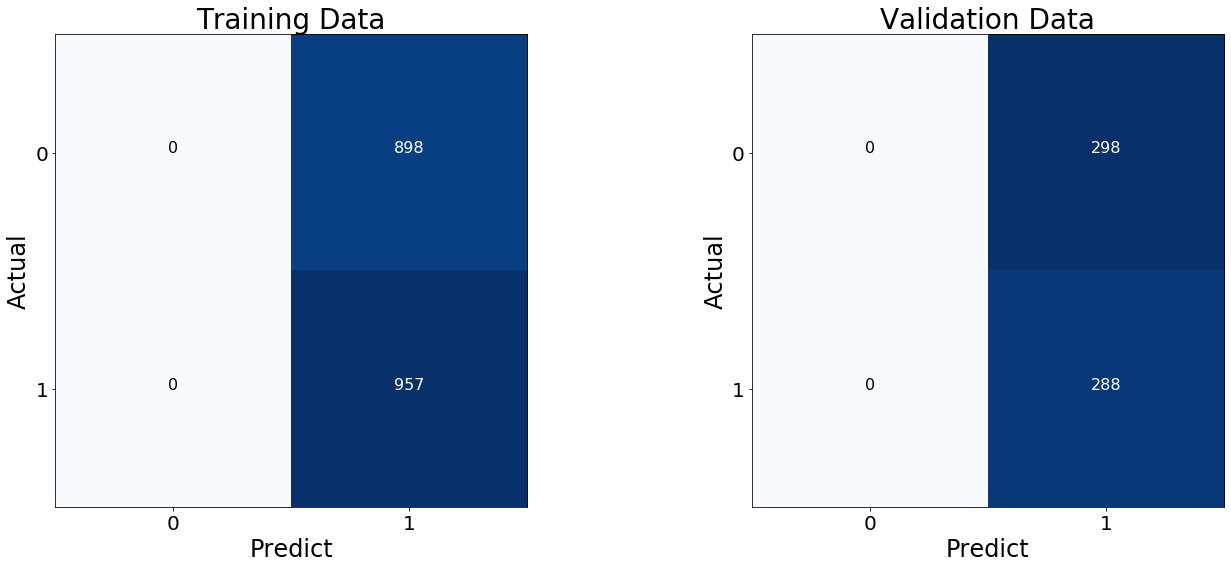

In [26]:
train_predictions = torch.max(cnn(train_dataset[0:size_train]['image']), 1)[1].data.numpy()
validation_predictions = torch.max(cnn(test_dataset[0:size_test]['image']), 1)[1].data.numpy()
plot_heatmaps(train_predictions, validation_predictions, train_dataset[0:size_train]['label'], test_dataset[0:size_test]['label'])